In [2]:
%matplotlib inline

#System
import os
import shutil

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from skimage.io import imread, imshow, imsave

#Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

In [3]:
img_shape = 256
batch_size = 4
num_classes = 32

In [4]:
def get_model(img_shape, num_classes):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_conv3 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv2)
    block4_upsa1 = UpSampling2D(2, interpolation="bilinear")(block4_conv3)

    block5_conc1 = Concatenate()([block3_conv3, block4_upsa1])
    block5_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conc1)
    block5_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv1)
    block5_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv2)
    block5_upsa1 = UpSampling2D(2, interpolation="bilinear")(block5_conv3)

    block6_conc1 = Concatenate()([block2_conv3, block5_upsa1])
    block6_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv2)
    block6_upsa1 = UpSampling2D(2, interpolation="bilinear")(block6_conv3)

    block7_conc1 = Concatenate()([block1_conv3, block6_upsa1])
    block7_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv2)
    
    block8_output = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(block7_conv3)

    return Model(inputs=block0_input, outputs=block8_output)

model = get_model(None, num_classes)

In [13]:
model.load_weights("checkpoints/w0_2/last_w.h5")

In [14]:
objects = []
with open("data/ADE20K_filtred/class_old_new_filt.csv") as f:
    for line in f:
        objects.append(line.split(";")[0])

In [40]:
def pred_img(path):
    img = imread(path)
    img = cv2.resize(img,(img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    for i in range(32):
        mask = pred[:, :, i]
        print(str(i), np.sum(mask) / img_shape /img_shape)
        
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray", norm=None)
        
        plt.title(objects[i])
        plt.show()
    return pred
        

0 0.6069688200950623


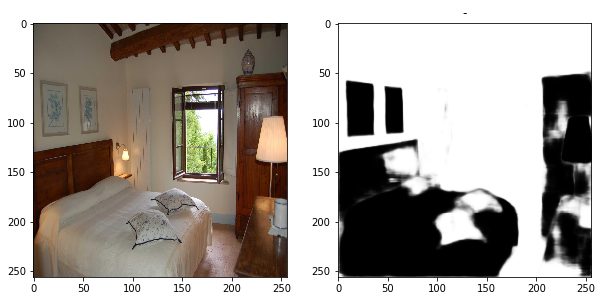

1 4.1977713408414274e-05


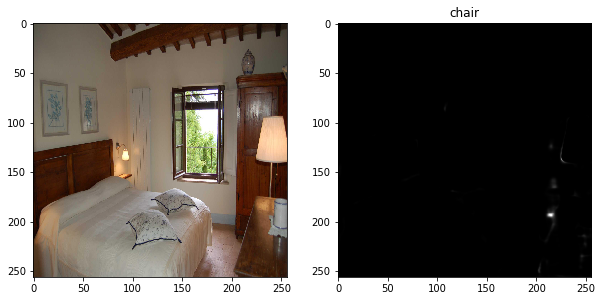

2 0.035191502422094345


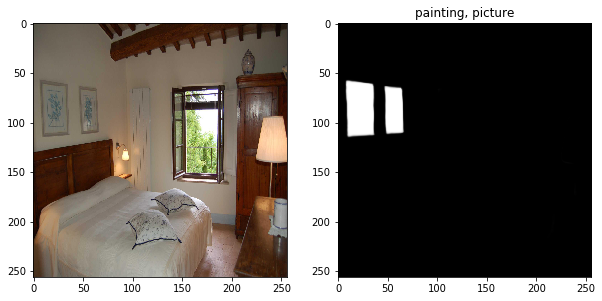

3 0.03374409303069115


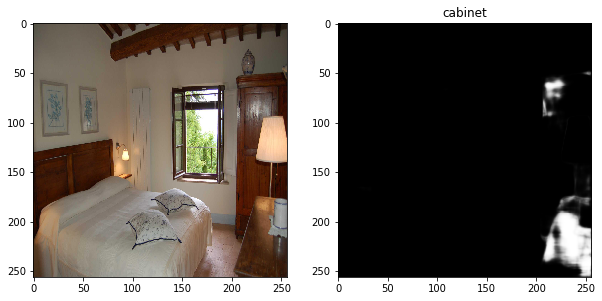

4 3.360608025104739e-05


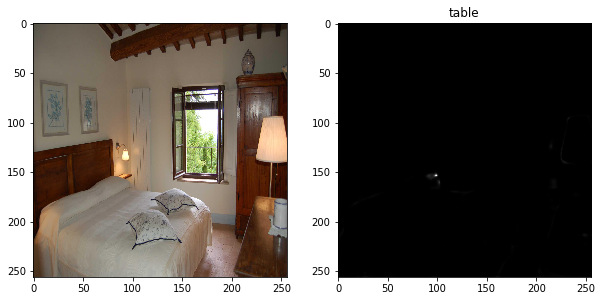

5 0.023807743564248085


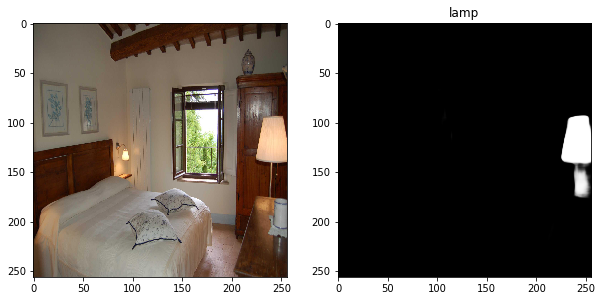

6 0.012249359861016273


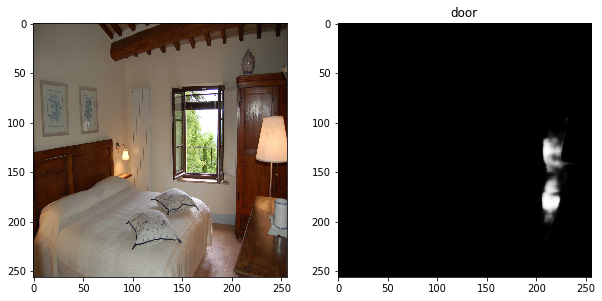

7 0.2382308691740036


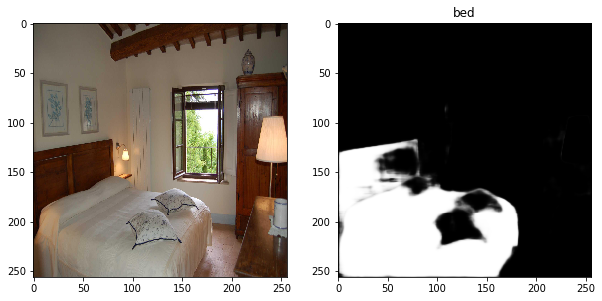

8 2.9784307571389945e-06


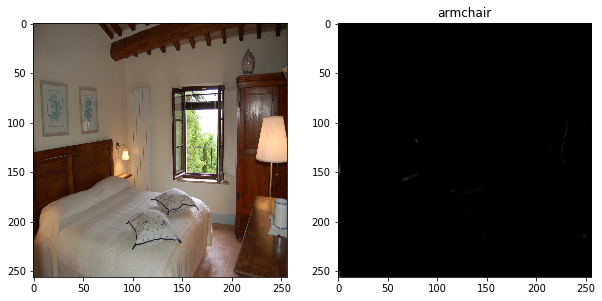

9 1.835148941609077e-05


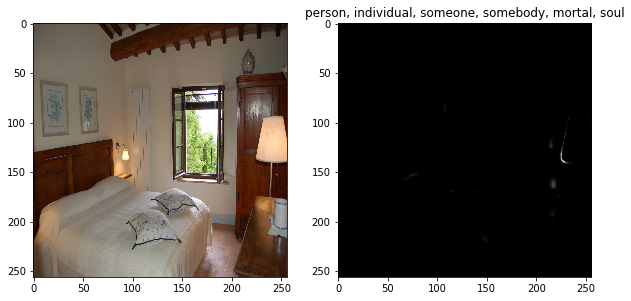

10 0.0025019263848662376


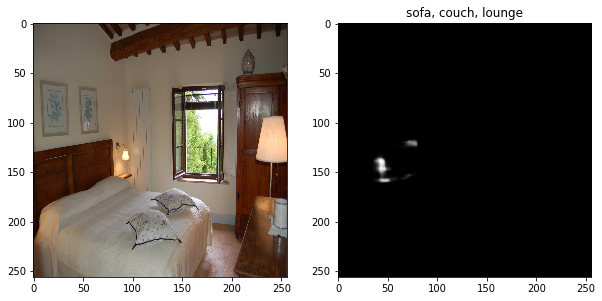

11 1.5449397324118763e-05


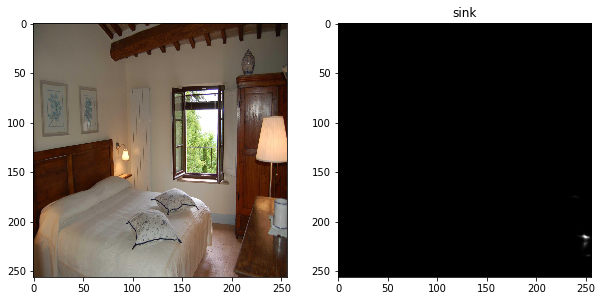

12 0.0001221929705934599


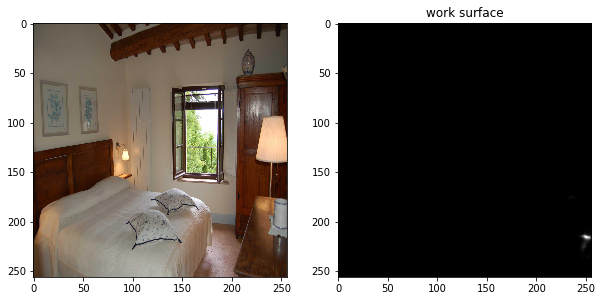

13 3.2279353035846725e-05


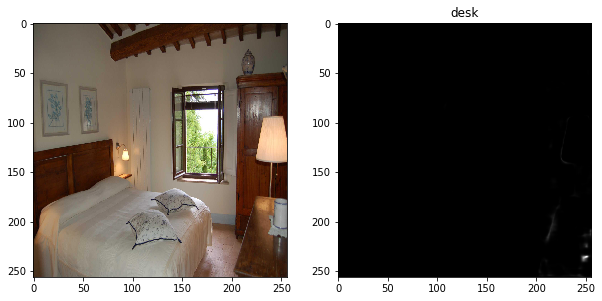

14 2.5342490062030265e-07


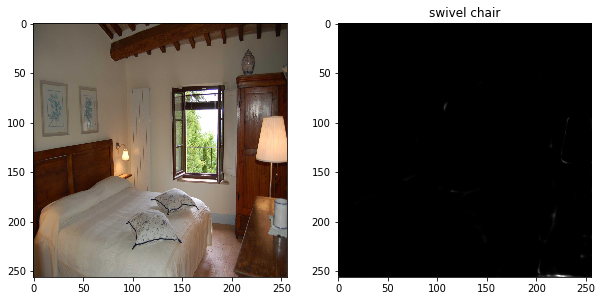

15 2.208889782195911e-06


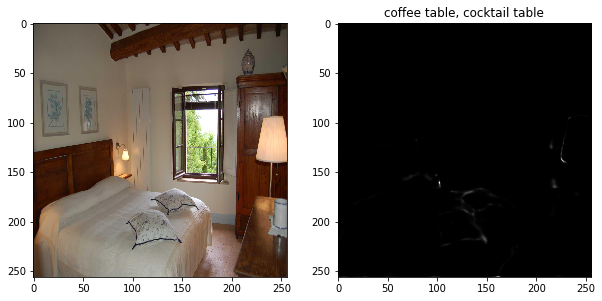

16 3.533526751198224e-06


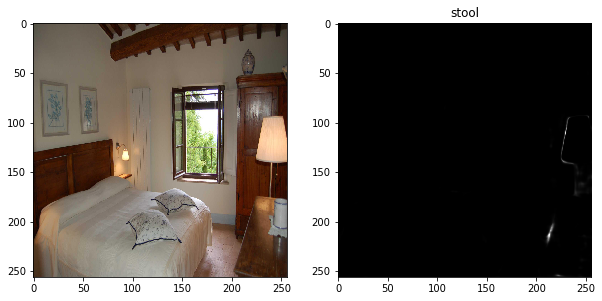

17 0.00010234023648081347


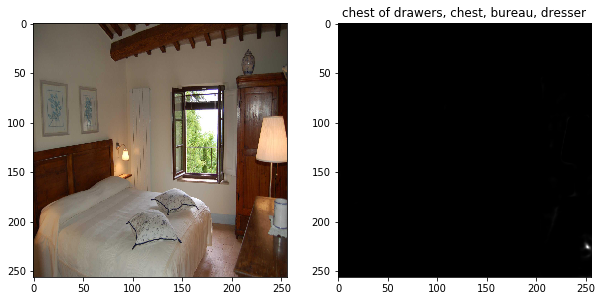

18 1.81486684596166e-05


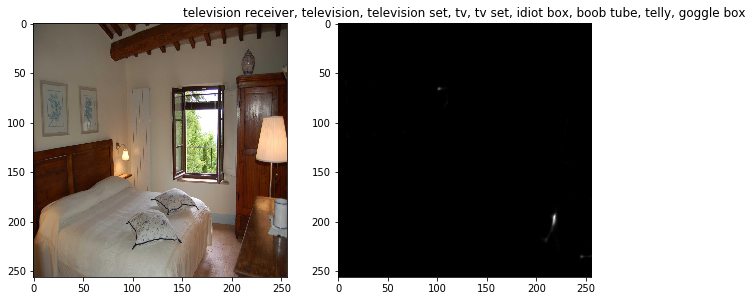

19 1.137737217504764e-05


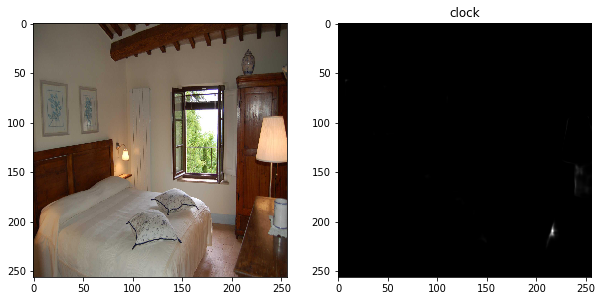

20 6.555764412041754e-05


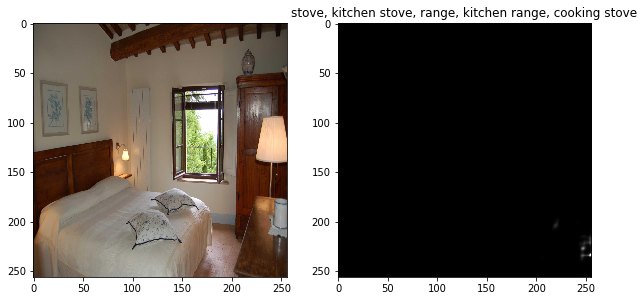

21 1.4356255633174442e-06


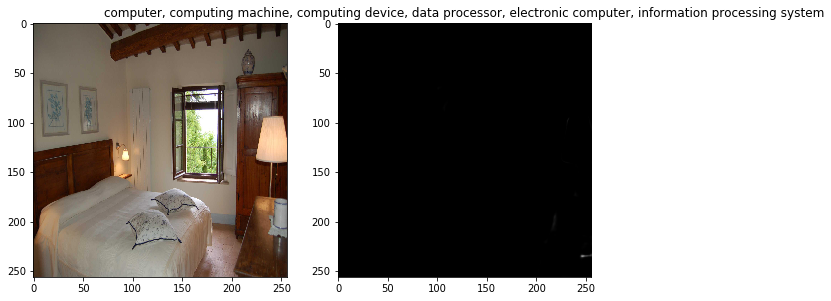

22 7.862564075367118e-07


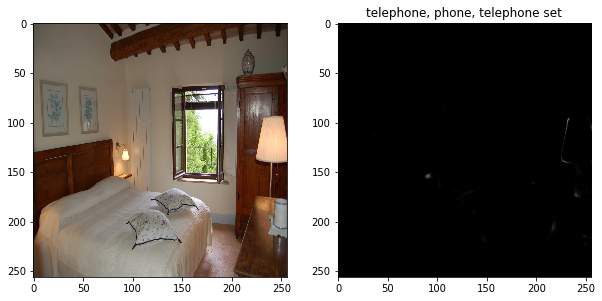

23 9.60851252784778e-07


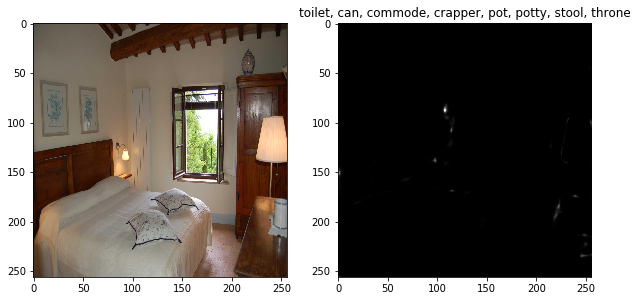

24 0.00010015719453804195


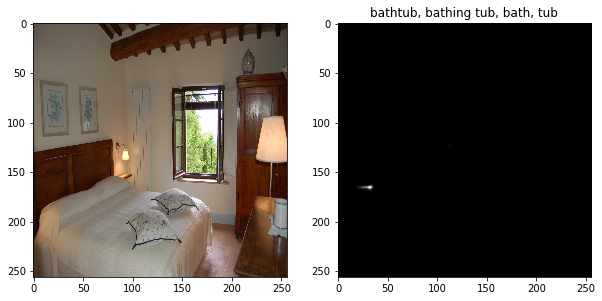

25 0.00058742641704157


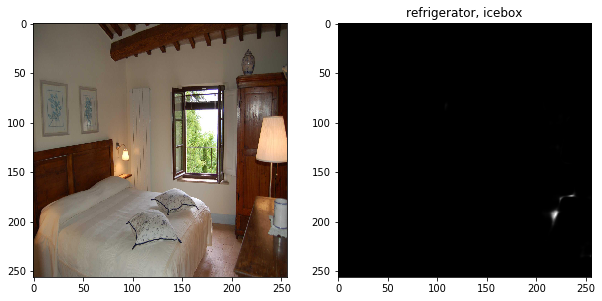

26 0.045940086245536804


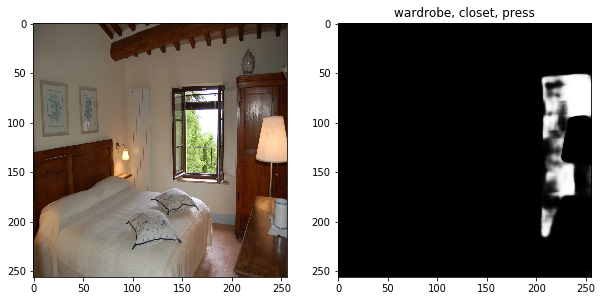

27 2.3880738808657043e-06


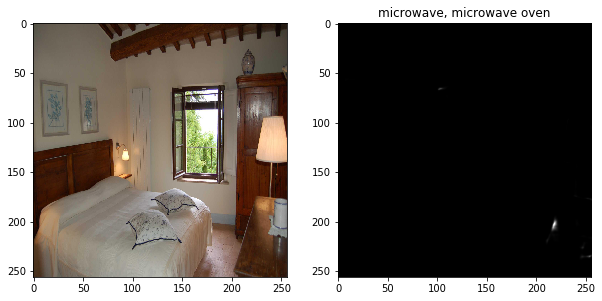

28 8.662153413752094e-05


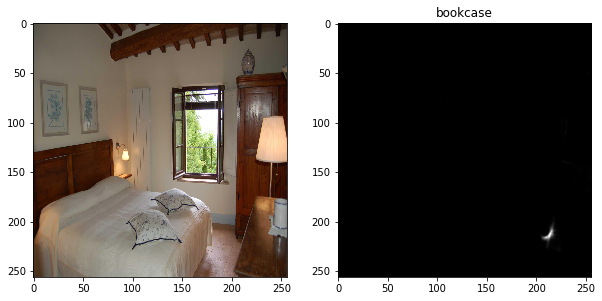

29 2.125582341250265e-06


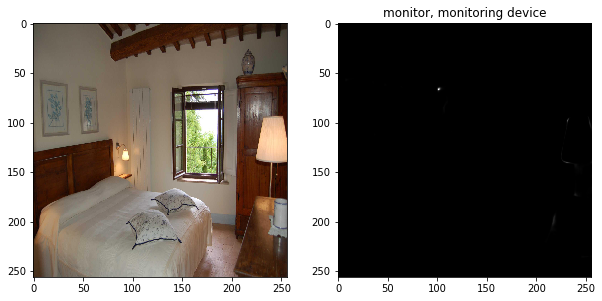

30 9.30548703763634e-05


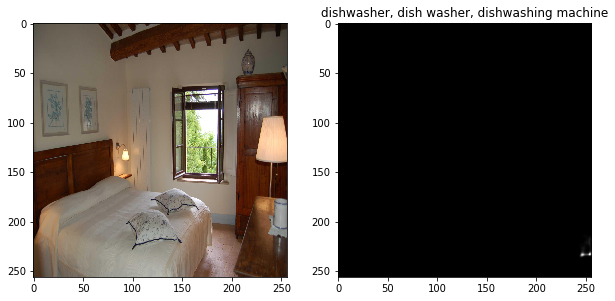

31 2.0460840460145846e-05


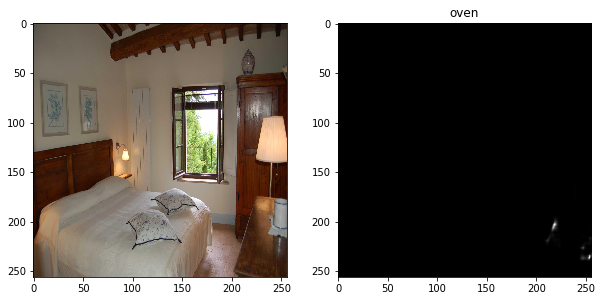

In [43]:
pred = pred_img('/home/rv/projects/InteriorRecognitionSystem/data/ADE20K_formated/train/img/img/00000263.jpg')

In [50]:
%%time
img = imread('/home/rv/projects/InteriorRecognitionSystem/data/ADE20K_formated/train/img/img/00000263.jpg')
img = cv2.resize(img,(img_shape, img_shape)) / 255
pred = model.predict(np.array([img]))[0]

CPU times: user 98 ms, sys: 20.5 ms, total: 119 ms
Wall time: 123 ms


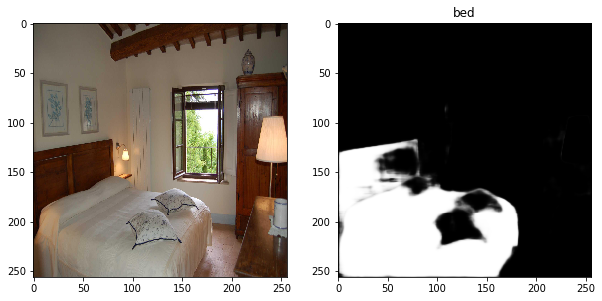

In [46]:
i = 7
mask = pred[:, :, i]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray", norm=None)
plt.title(objects[i])
plt.show()